In [45]:
import os
import sys 
import glob
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [46]:
# TODO include for and aft viewing geometry in addition to mid, to obtain mutliple velocity vectors

In [57]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"#Carrib_20231104/"  #Carrib_20231104  Morroco_20201103
files = glob.glob(f"{data_dir}*")
scenarios = [file[file.rfind('/') + 1:] for file in files]
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Iceland_20231107',
 'Scotland_20231109']

In [59]:
scenario = 'Morroco_20201103' #scenarios[-1]
files = glob.glob(f"{data_dir + scenario}/*")
files


['/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185227_20201103T185252_035088_04182F_3597.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185047_20201103T185112_035088_04182F_966E.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185137_20201103T185202_035088_04182F_BC59.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185112_20201103T185137_035088_04182F_6475.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185202_20201103T185227_035088_04182F_D53C.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185022_20201103T185047_035088_04182F_2DB3.SAFE',
 '/Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/S1A_IW_GRDH_1SDV_20201103T185252_20201103T185319_035088_04182F_0831.SAFE',
 '/Users/opod

In [32]:
# test_files = [files[i] for i in [0,1,5]] # [1,2,5]

az_mask_cutoff = 80_000

test = S1DopplerLeakage(
    filename=files,
    az_mask_cutoff=az_mask_cutoff
    # era5_nc='era520201110.nc',
    )

In [33]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_Doppler_leakage()

In [33]:
test.open_data()
test.S1_file.latitude.mean(), test.S1_file.longitude.mean()

(<xarray.DataArray 'latitude' ()>
 array(38.62118914),
 <xarray.DataArray 'longitude' ()>
 array(-13.58099695))

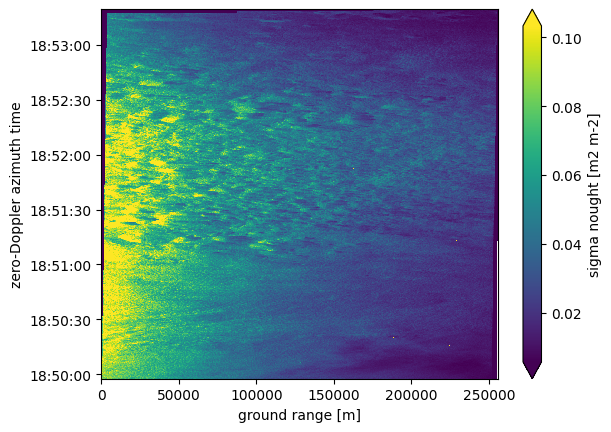

In [35]:
test.S1_file.NRCS_VV.plot(robust = True)

In [34]:
test.apply()

2023-11-23 14:58:18,986 INFO Welcome to the CDS
2023-11-23 14:58:18,987 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-23 14:58:19,072 INFO Request is queued
2023-11-23 15:02:37,558 INFO Request is completed
2023-11-23 15:02:37,559 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data5/adaptor.mars.internal-1700748152.451572-16188-1-47c883e0-5de3-4255-8816-7f75dc32f083.nc to era520201103.nc (1.3K)
2023-11-23 15:02:38,148 INFO Download rate 2.3K/s


['Carrib_20231104', 'Azores_20201127', 'Hawaii_20201106', 'Barbedos_20201110', 'Morroco_20201103', 'Iceland_20231107', 'Scotland_20231109']
['Carrib_20231104', 'Azores_20201127', 'Hawaii_20201106', 'Barbedos_20201110', 'Morroco_20201103', 'Iceland_20231107', 'Scotland_20231109']
['Carrib_20231104', 'Azores_20201127', 'Hawaii_20201106', 'Barbedos_20201110', 'Morroco_20201103', 'Iceland_20231107', 'Scotland_20231109']
['Carrib_20231104', 'Azores_20201127', 'Hawaii_20201106', 'Barbedos_20201110', 'Morroco_20201103', 'Iceland_20231107', 'Scotland_20231109']
['Carrib_20231104', 'Azores_20201127', 'Hawaii_20201106', 'Barbedos_20201110', 'Morroco_20201103', 'Iceland_20231107', 'Scotland_20231109']


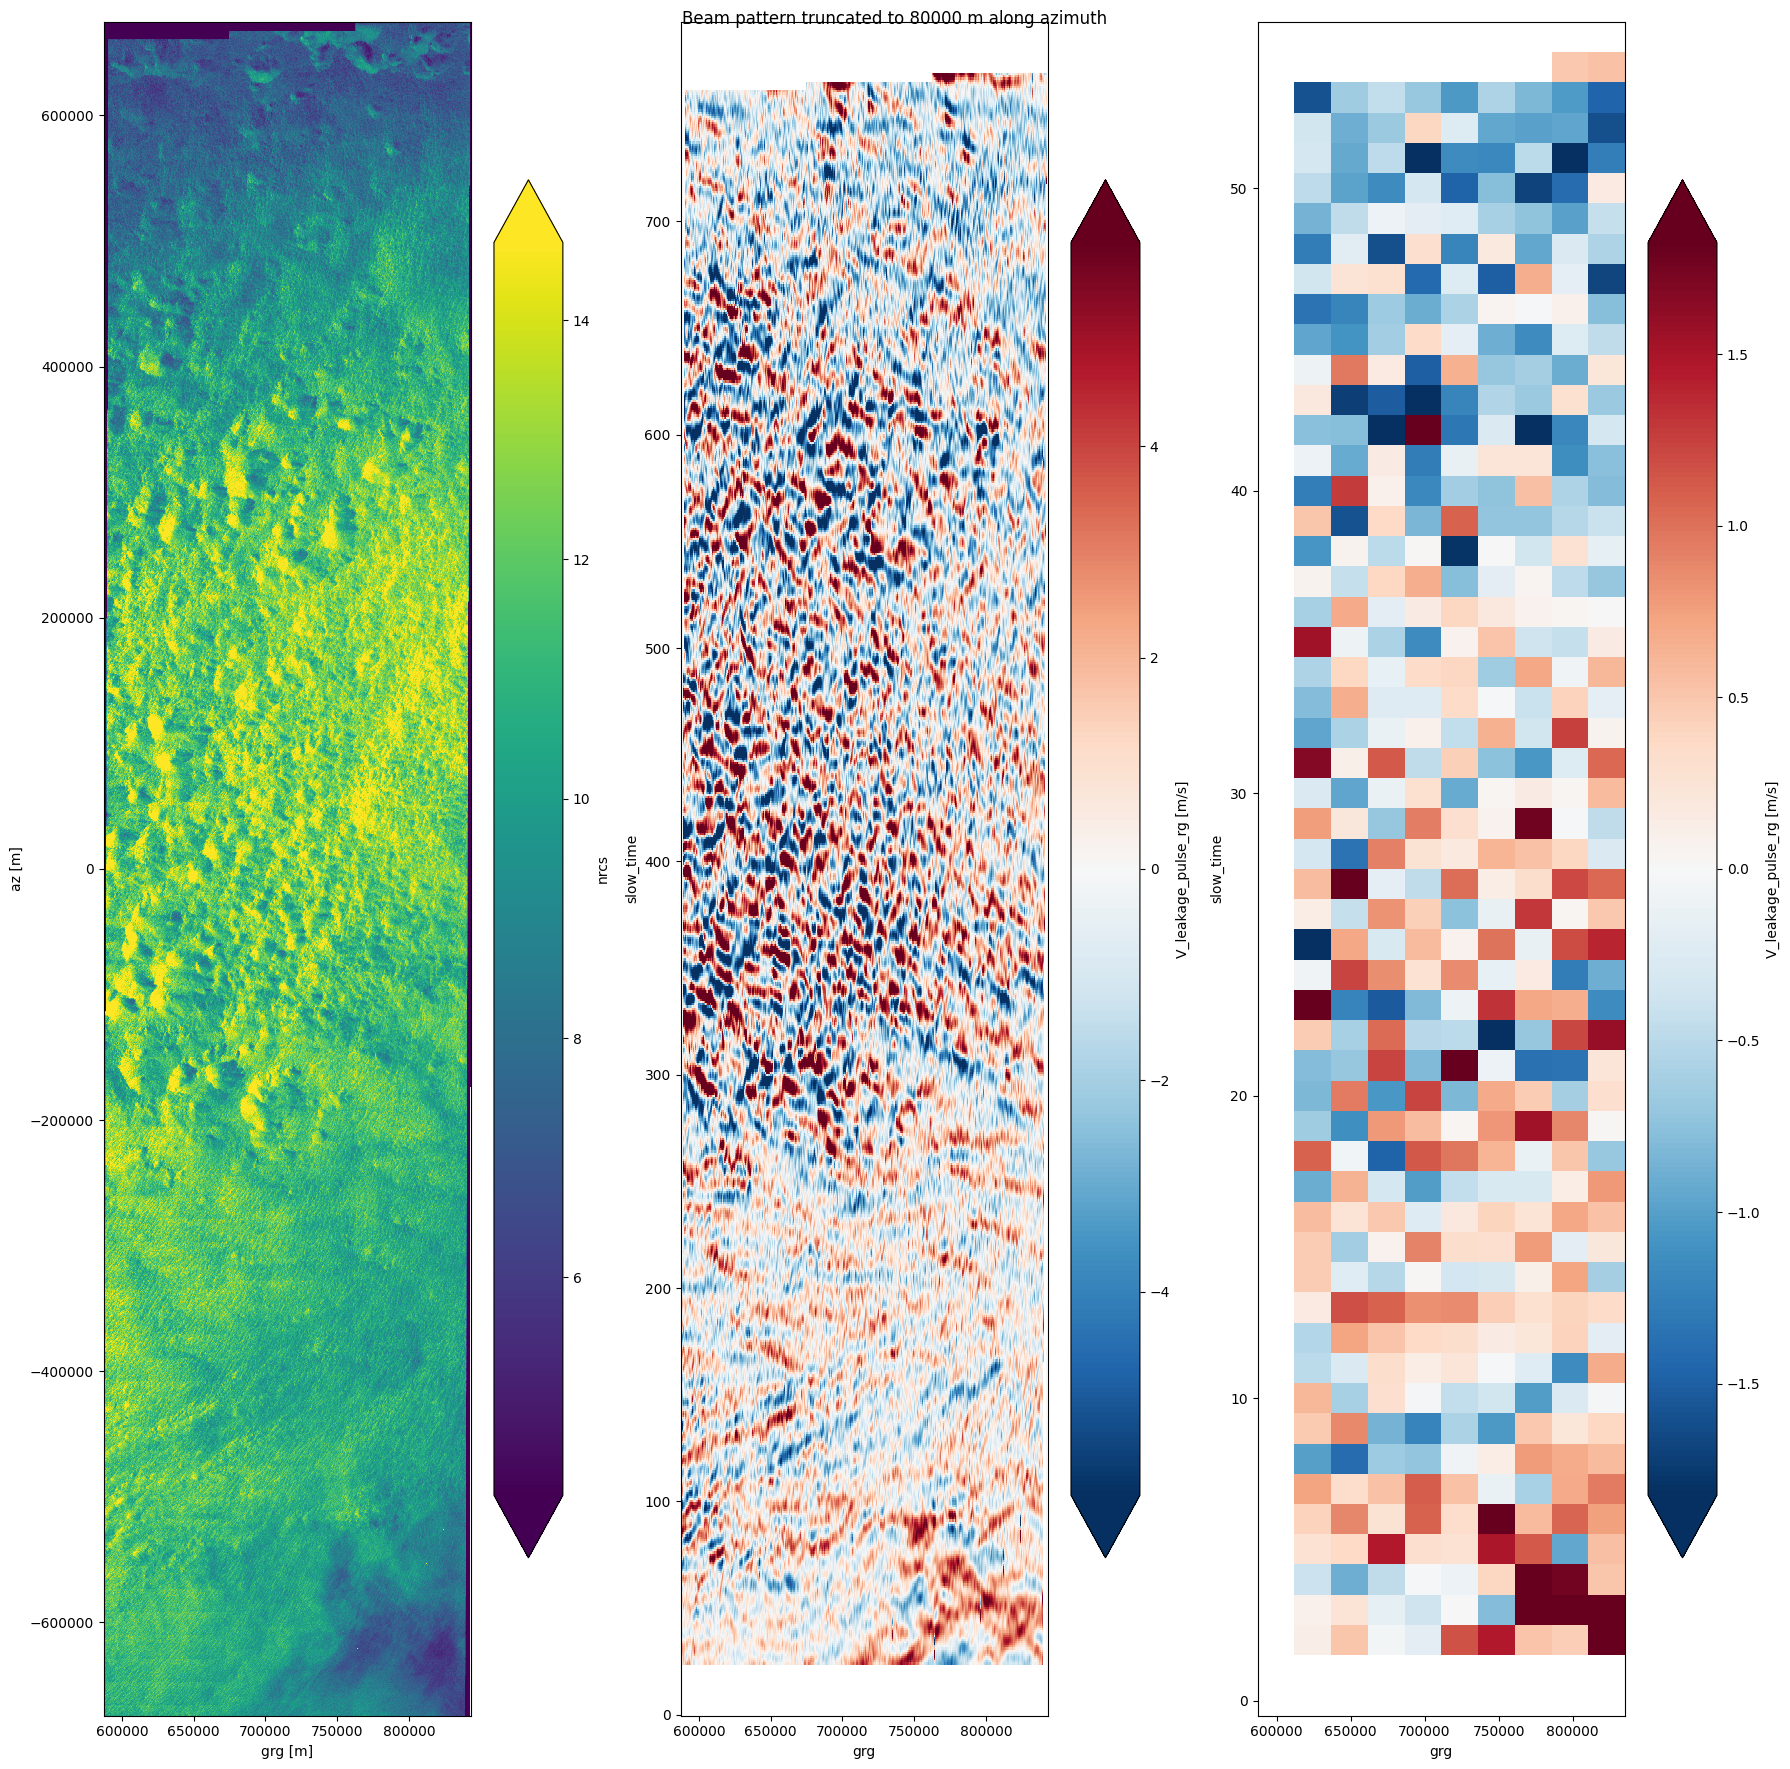

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(18, 18), sharex=False)

test.windfield.plot(robust=True, ax = axes[0])
test.data.V_leakage_pulse_rg.T.plot(robust = True, ax = axes[1])
test.subscenes.V_leakage_pulse_rg.T.plot(robust = True, ax = axes[2])

fig.suptitle(f'Beam pattern truncated to {az_mask_cutoff} m along azimuth')
fig.tight_layout()

In [70]:
# test.data[['doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat']].to_netcdf("scatt4ML2.nc")